In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Ejemplo: Evaluación con datos fuera de muestra
import yfinance as yf

In [5]:
df_original = yf.Ticker('NQ=F')
df_original = df_original.history(start='2010-01-01', end='2024-01-01')

### Separar los datos en entrenamiento (80%) y validación (20%)


In [7]:
train_size = int(len(df_original) * 0.8)
train_data = df_original[:train_size]
validation_data = df_original[train_size:]

### Función de backtest para cada combinación de parámetros


In [8]:
def backtest_strategy(data, sma_1, sma_2):
    df = data.copy()
    df['SMA_1'] = df['Close'].rolling(window=sma_1).mean()
    df['SMA_2'] = df['Close'].rolling(window=sma_2).mean()

    df['Signal'] = 0
    df.loc[df['SMA_1'] > df['SMA_2'], 'Signal'] = 1
    df.loc[df['SMA_1'] < df['SMA_2'], 'Signal'] = -1

    df['Position'] = df['Signal'].shift()
    df['Strategy_Returns'] = df['Position'] * df['Close'].pct_change()

    df.dropna(inplace=True)

    # Retornar el DataFrame con los cálculos
    return df

### Rango de valores para la optimización


In [9]:
sma_1_range = range(10, 50, 5)
sma_2_range = range(100, 300, 25)

### Optimización con Grid Search en el conjunto de entrenamiento


In [10]:
best_params = None
best_return_train = -np.inf

In [11]:
for sma_1 in sma_1_range:
    for sma_2 in sma_2_range:
        df_train_result = backtest_strategy(train_data, sma_1, sma_2)
        total_return_train = (df_train_result['Strategy_Returns'] + 1).prod() - 1
        print(f'Probando SMA_1: {sma_1}, SMA_2: {sma_2} - Rendimiento en Entrenamiento: {total_return_train:.2%}')

        if total_return_train > best_return_train:
            best_return_train = total_return_train
            best_params = (sma_1, sma_2)

Probando SMA_1: 10, SMA_2: 100 - Rendimiento en Entrenamiento: -38.29%
Probando SMA_1: 10, SMA_2: 125 - Rendimiento en Entrenamiento: 4.94%
Probando SMA_1: 10, SMA_2: 150 - Rendimiento en Entrenamiento: -6.87%
Probando SMA_1: 10, SMA_2: 175 - Rendimiento en Entrenamiento: 22.53%
Probando SMA_1: 10, SMA_2: 200 - Rendimiento en Entrenamiento: 26.16%
Probando SMA_1: 10, SMA_2: 225 - Rendimiento en Entrenamiento: 25.47%
Probando SMA_1: 10, SMA_2: 250 - Rendimiento en Entrenamiento: 27.94%
Probando SMA_1: 10, SMA_2: 275 - Rendimiento en Entrenamiento: 15.93%
Probando SMA_1: 15, SMA_2: 100 - Rendimiento en Entrenamiento: -17.53%
Probando SMA_1: 15, SMA_2: 125 - Rendimiento en Entrenamiento: 44.91%
Probando SMA_1: 15, SMA_2: 150 - Rendimiento en Entrenamiento: 17.02%
Probando SMA_1: 15, SMA_2: 175 - Rendimiento en Entrenamiento: 8.99%
Probando SMA_1: 15, SMA_2: 200 - Rendimiento en Entrenamiento: 24.09%
Probando SMA_1: 15, SMA_2: 225 - Rendimiento en Entrenamiento: 33.77%
Probando SMA_1: 15, 

In [12]:
print(f'\nMejores parámetros en entrenamiento: SMA_1: {best_params[0]}, SMA_2: {best_params[1]} con un rendimiento total de {best_return_train:.2%}')


Mejores parámetros en entrenamiento: SMA_1: 40, SMA_2: 275 con un rendimiento total de 152.80%


### Evaluar en el conjunto de validación con los mejores parámetros


In [13]:
df_validation_result = backtest_strategy(validation_data, best_params[0], best_params[1])
best_return_validation = (df_validation_result['Strategy_Returns'] + 1).prod() - 1

In [14]:
print(f'Rendimiento en validación con los mejores parámetros: {best_return_validation:.2%}')

Rendimiento en validación con los mejores parámetros: 30.13%


### Calcular rendimientos acumulados de entrenamiento


In [16]:
train_cumulative_returns = np.cumprod(df_train_result['Strategy_Returns'] + 1)

### Calcular rendimientos acumulados de validación, comenzando desde el último valor de entrenamiento

In [17]:
last_train_value = train_cumulative_returns.iloc[-1]
validation_cumulative_returns = np.cumprod(df_validation_result['Strategy_Returns'] + 1) * last_train_value

### Graficar resultados de entrenamiento y validación solapados


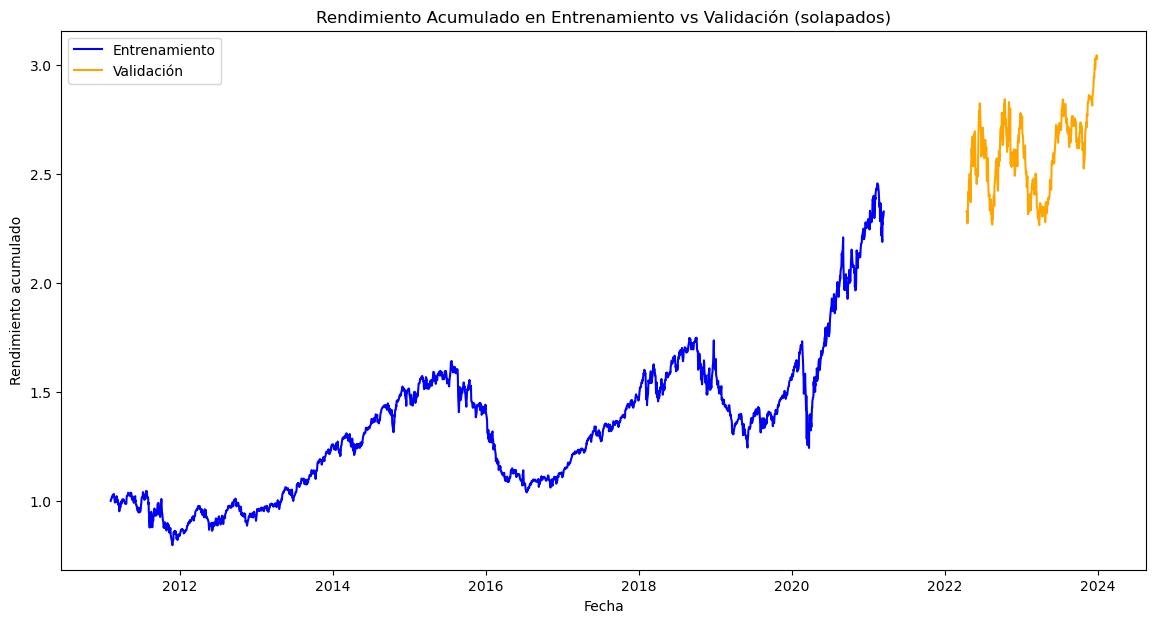

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(train_cumulative_returns, label='Entrenamiento', color='blue')
plt.plot(validation_cumulative_returns, label='Validación', color='orange')
plt.title('Rendimiento Acumulado en Entrenamiento vs Validación (solapados)')
plt.xlabel('Fecha')
plt.ylabel('Rendimiento acumulado')
plt.legend()
plt.show()